<img src="../images/logos/wradlib_logo.svg.png" width=250 alt="wradlib logo png"></img>

# wradlib radar data io, visualisation, gridding and gis export

---

## Overview

Within this notebook, we will cover:

1. Reading radar volume data into xarray based RadarVolume
1. Examination of RadarVolume and Sweeps
1. Plotting of sweeps, simple and mapmaking

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Xarray Basics](https://tutorial.xarray.dev/intro.html) | Helpful | Basic Dataset/DataArray |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Helpful | Basic Plotting |
| [Cartopy Basics](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Projections |
| [GDAL Basiscs](https://gdal.org/api/python_bindings.html) | Helpful | Raster |

- **Time to learn**: 15 minutes

---

## Imports

In [1]:
import glob
import pathlib

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from matplotlib import ticker as tick
from osgeo import gdal

import wradlib as wrl
import datatree as dt

## Import data into RadarVolume

We have this special case here with Rainbow data where moments are splitted across files. Each file nevertheless consists of all sweeps comprising the volume. We'll use some special nested ordering to read the files.

In [2]:
fglob = "data/rainbow/meteoswiss/*.vol"

In [3]:
vol = wrl.io.open_rainbow_mfdataset(fglob, combine="by_coords", concat_dim=None)

/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/wradlib/io/rainbow.py:222: FutureWarning: `open_rainbow_mfdataset` is deprecated and will be removed in 2.0. Future development will take place in `xradar`-package.
  return open_radar_mfdataset(


  0%|          | 0/10 [00:00<?, ?it/s]

### Examine RadarVolume

The RadarVolume is a shallow class which tries to comply to CfRadial2/WMO-FM301, see [WMO-CF_Extensions](https://community.wmo.int/activity-areas/wis/wmo-cf-extensions).

The printout of `RadarVolume` just lists the dimensions and the associated elevations.

In [4]:
display(vol)

<wradlib.RadarVolume>
Dimension(s): (sweep: 10)
Elevation(s): (0.0, 1.3, 2.9, 4.9, 7.3, 10.2, 13.8, 18.2, 23.5, 30.0)

### Root Group

The root-group is essentially an overview over the volume, more or less aligned with CfRadial metadata.

In [5]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2019-10-21T08:24:09Z'
    time_coverage_end    <U20 '2019-10-21 08:29:34Z'
    latitude             float64 46.77
    longitude            float64 6.954
    altitude             float64 735.0
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 0.0 1.3 2.9 4.9 ... 13.8 18.2 23.5 30.0
Attributes:
    version:          None
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    fixed_angle:      0.0

### Sweep Groups

Sweeps are available in a sequence attached to the `RadarVolume` object.

In [6]:
swp = vol[0]
display(swp)

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    elevation          (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime              (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 6.954
    latitude           float64 46.77
    altitude           float64 735.0
    time               datetime64[ns] 2019-10-21T08:24:09.041666500
Data variables:
    DBZH               (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    sweep_number       int64 0
    prt_mode           <U7 'not_set'
    follow_mode        <U7 'not_set'
    sweep_fixed_angle  float64 0.0
    KDP                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
Attributes:
    fixed_angle:  0.0

## Inspect Scan Strategy

Considering volume files it's nice to have an overview over the scan strategy. We can choose some reasonable values for the layout.

In [7]:
nrays = 360
nbins = 150
range_res = 1000.0
ranges = np.arange(nbins) * range_res
elevs = vol.root.sweep_fixed_angle.values
sitecoords = (
    vol.root.longitude.values.item(),
    vol.root.latitude.values.item(),
    vol.root.altitude.values.item(),
)

beamwidth = 1.0

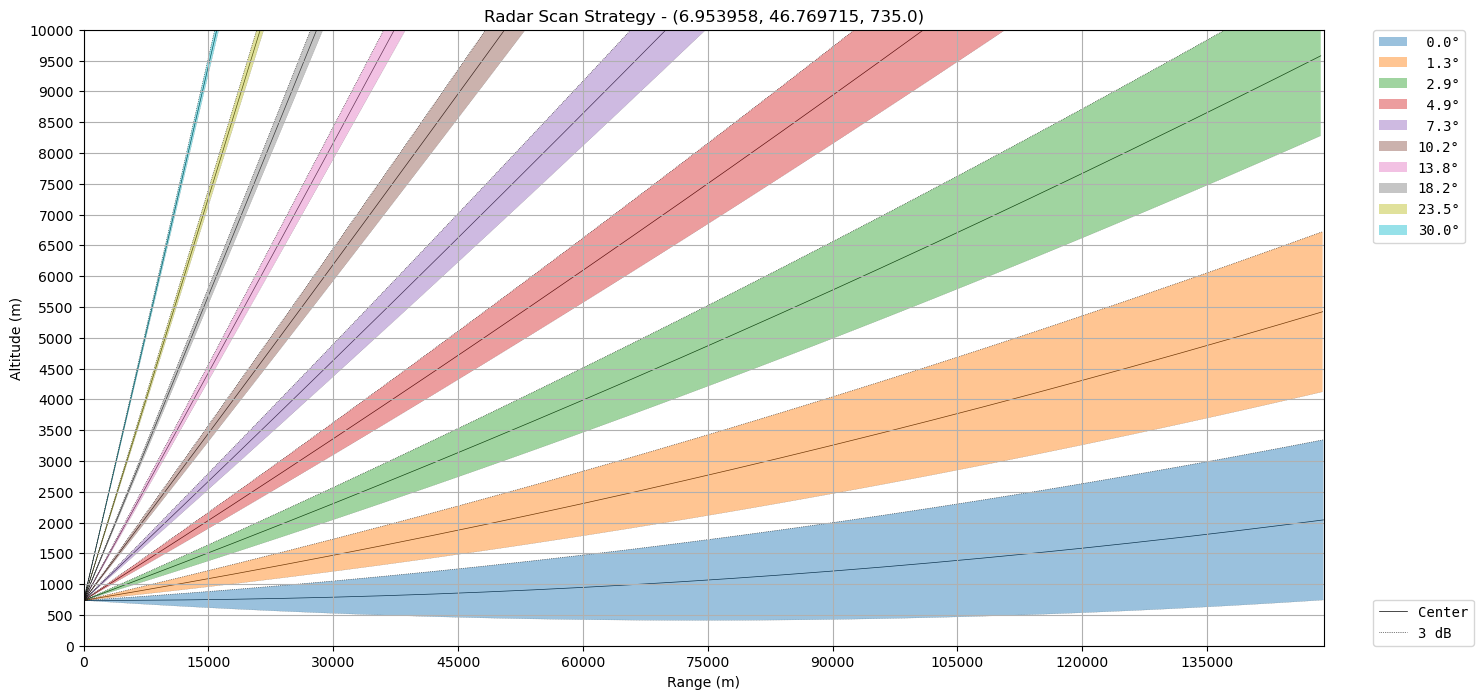

In [8]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords)

We can plot it on top of the terrain derived from SRTM DEM.

In [9]:
import os

os.environ["WRADLIB_EARTHDATA_BEARER_TOKEN"] = ""
os.environ["WRADLIB_DATA"] = "data/wradlib-data"

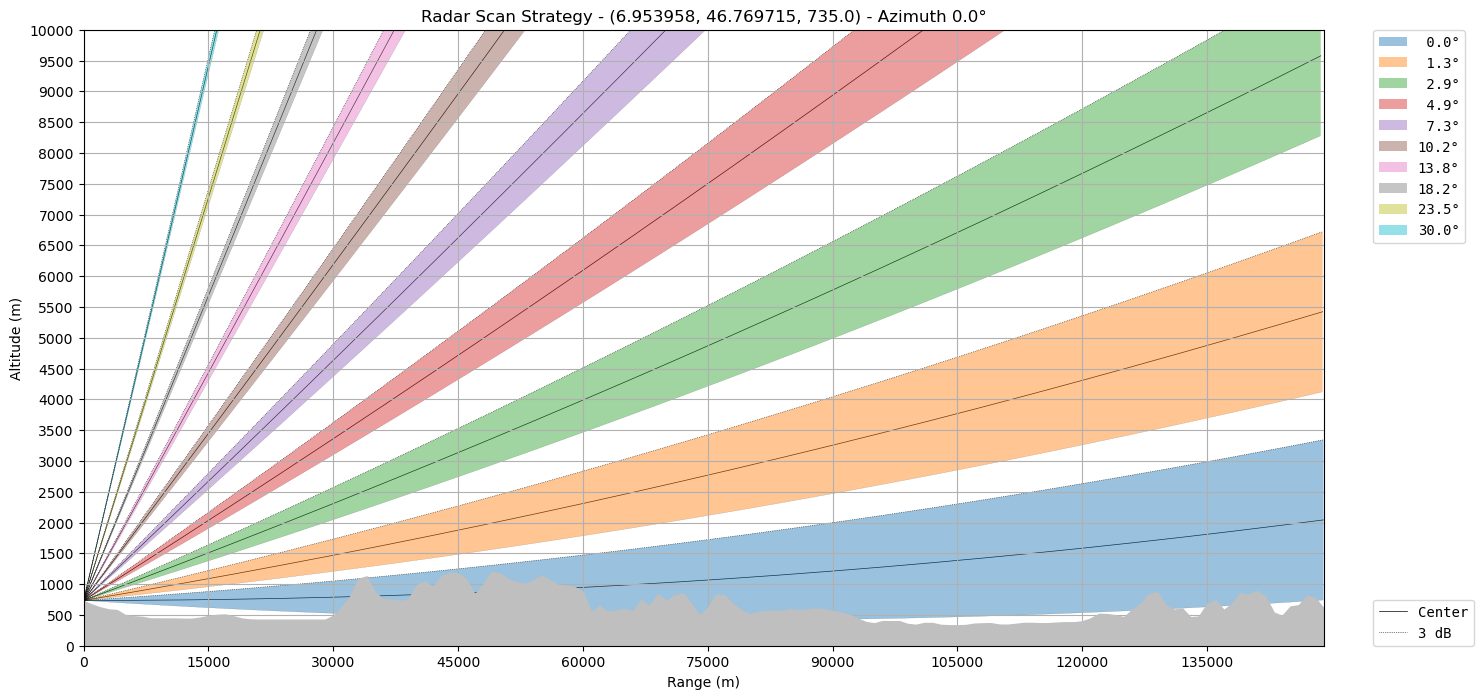

In [10]:
ax = wrl.vis.plot_scan_strategy(ranges, elevs, sitecoords, terrain=True)

Let's make the earth go round...

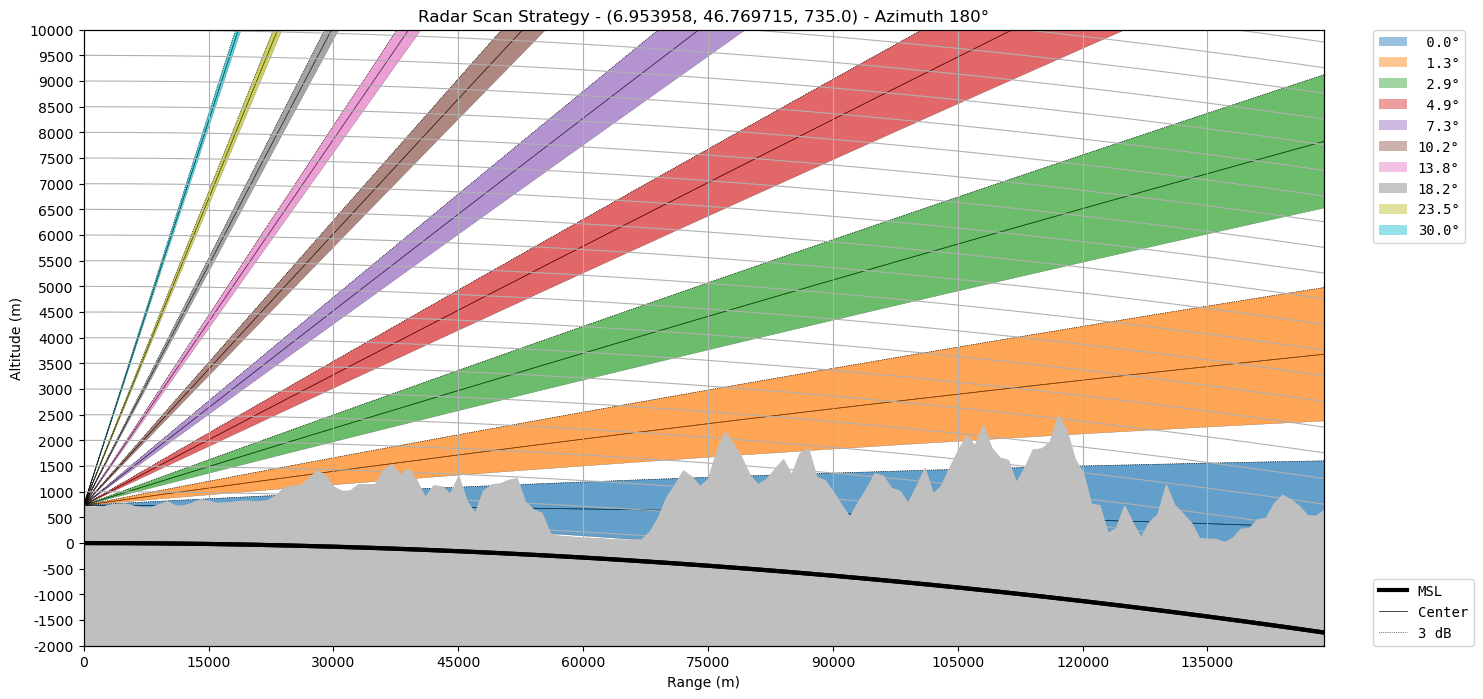

In [11]:
ax = wrl.vis.plot_scan_strategy(
    ranges, elevs, sitecoords, cg=True, terrain=True, az=180
)

## Plotting Radar Data
### Time vs. Azimuth

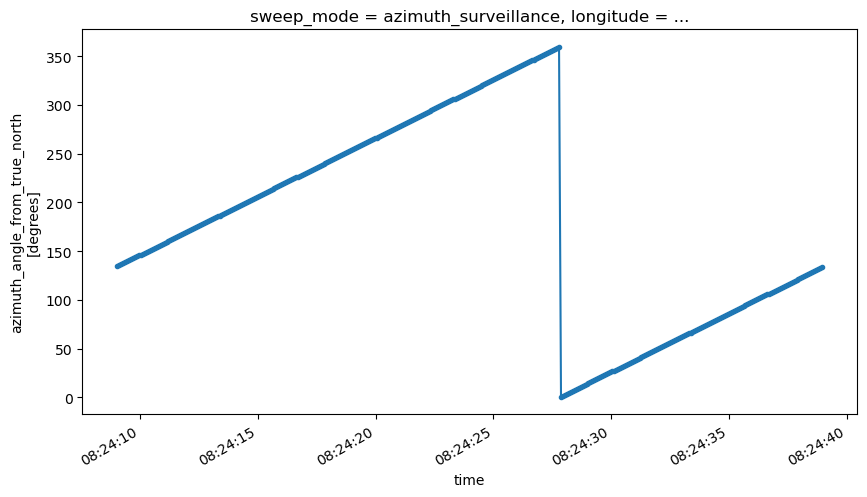

In [12]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(111)
swp.azimuth.sortby("rtime").plot(x="rtime", marker=".")

In [13]:
swp

<xarray.Dataset>
Dimensions:            (azimuth: 360, range: 1400)
Coordinates:
  * azimuth            (azimuth) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * range              (range) float32 25.0 75.0 125.0 ... 6.992e+04 6.998e+04
    elevation          (azimuth) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    rtime              (azimuth) datetime64[ns] dask.array<chunksize=(360,), meta=np.ndarray>
    sweep_mode         <U20 'azimuth_surveillance'
    longitude          float64 6.954
    latitude           float64 46.77
    altitude           float64 735.0
    time               datetime64[ns] 2019-10-21T08:24:09.041666500
Data variables:
    DBZH               (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    sweep_number       int64 0
    prt_mode           <U7 'not_set'
    follow_mode        <U7 'not_set'
    sweep_fixed_angle  float64 0.0
    KDP                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    PHIDP              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    RHOHV              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    VRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    WRADH              (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
    ZDR                (azimuth, range) float32 dask.array<chunksize=(360, 1400), meta=np.ndarray>
Attributes:
    fixed_angle:  0.0

### Range vs. Azimuth/Time

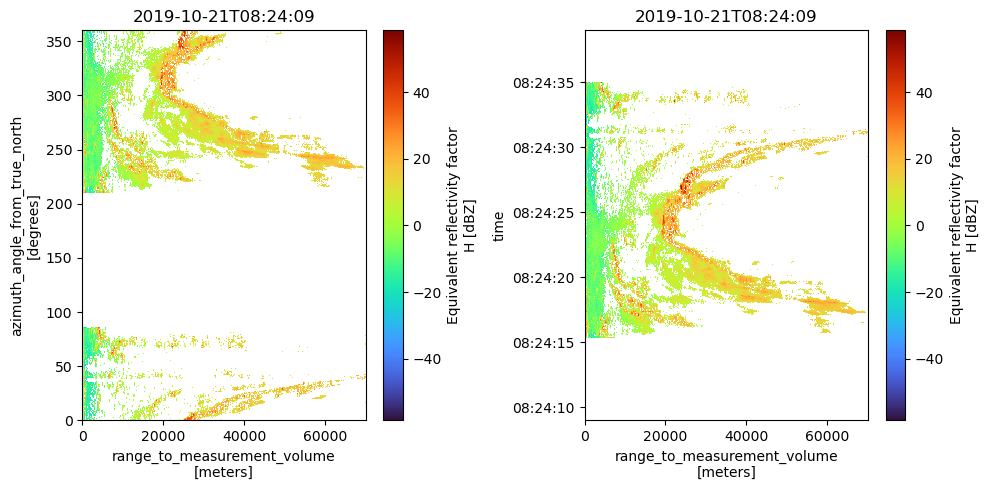

In [14]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
swp.DBZH.plot(cmap="turbo", ax=ax1)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax2 = fig.add_subplot(122)
swp.DBZH.sortby("rtime").plot(y="rtime", cmap="turbo", ax=ax2)
ax2.set_title(f"{swp.time.values.astype('M8[s]')}")
plt.tight_layout()

### Georeferenced as Plan Position Indicator

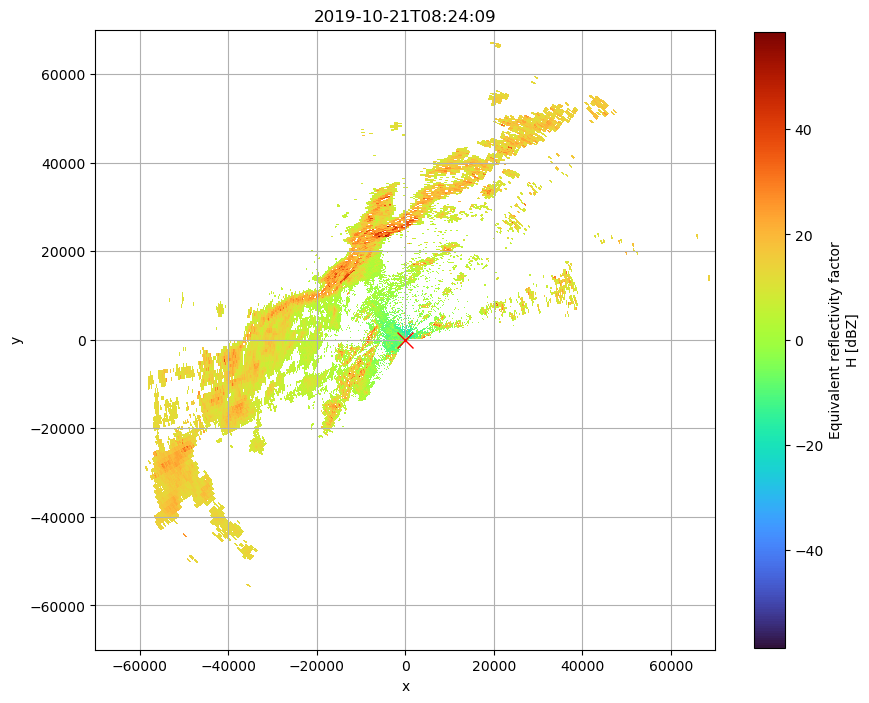

In [15]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(111)
swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(
    x="x", y="y", ax=ax1, cmap="turbo", cbar_kwargs=dict(shrink=0.8)
)
ax1.plot(0, 0, "rx", markersize=12)
ax1.set_title(f"{swp.time.values.astype('M8[s]')}")
ax1.grid()
ax1.set_aspect("equal")

### Basic MapMaking with cartopy

The data will be georeferenced as `Azimuthal Equidistant Projection` centered at the radar. For the map projection we will use `Mercator`.

In [16]:
map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=swp.latitude.values, central_longitude=swp.longitude.values
)
map_proj = ccrs.Mercator(central_longitude=swp.longitude.values)

In [17]:
def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="cultural", name="admin_0_countries", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)

/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mgrover/mambaforge/envs/ams-open-radar-2023-dev/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


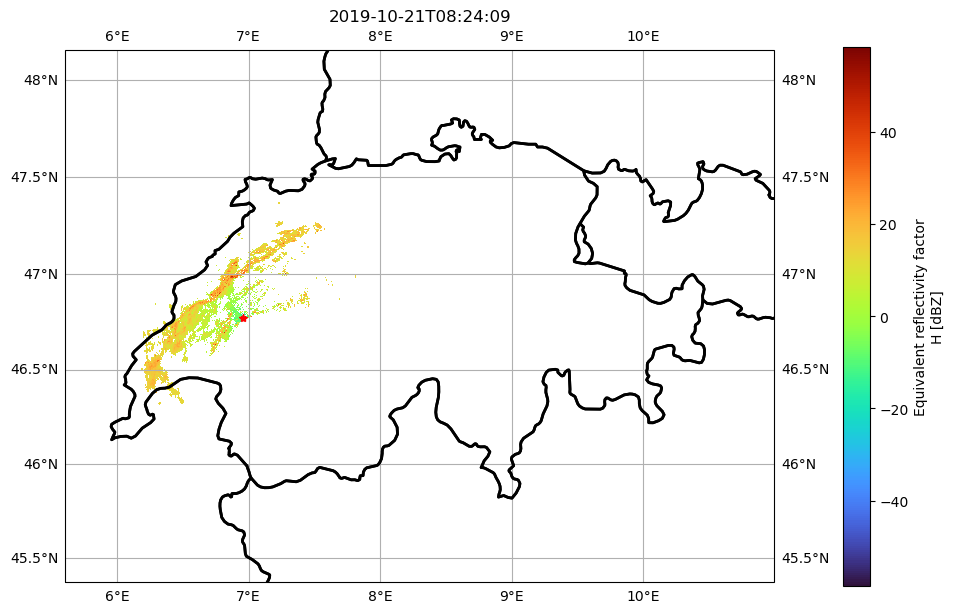

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
cbar_kwargs = dict(shrink=0.7, pad=0.075)
pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).plot(
    ax=ax, x="x", y="y", cbar_kwargs=cbar_kwargs, cmap="turbo", transform=map_trans
)
plot_borders(ax)
ax.gridlines(draw_labels=True)
ax.plot(
    swp.longitude.values, swp.latitude.values, transform=map_trans, marker="*", c="r"
)
ax.set_title(f"{swp.time.values.astype('M8[s]')}")
ax.set_xlim(-15e4, 45e4)
ax.set_ylim(565e4, 610e4)
plt.tight_layout()

### Plot on curvelinear grid

For Xarray DataArrays wradlib uses a so-called accessor (`wradlib`). To plot on curvelinear grids projection has to be set to `cg`, which uses the matplotlib AXISARTIS namespace.

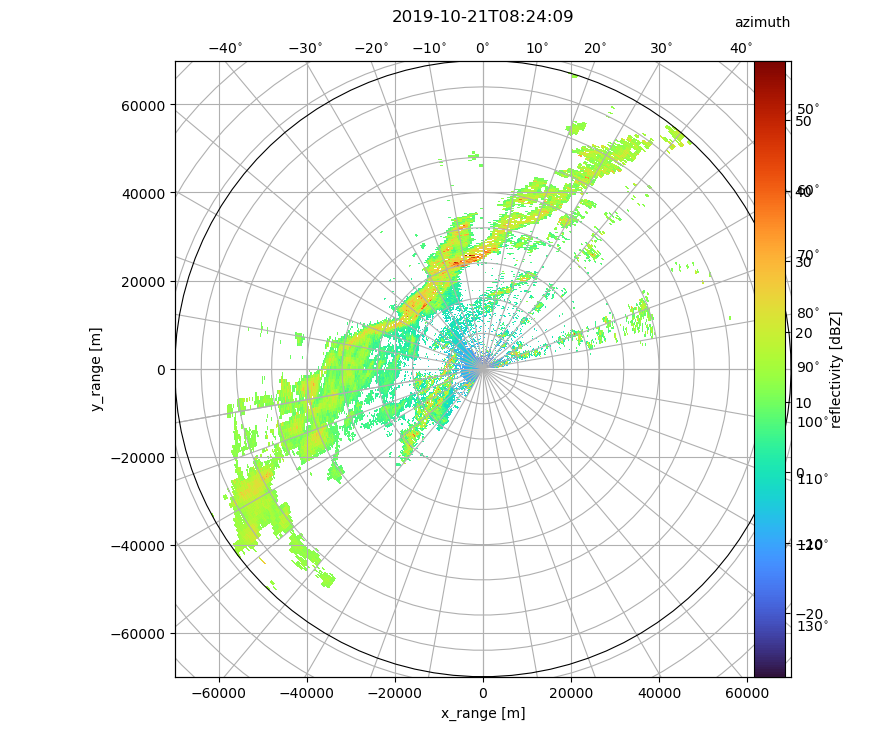

In [19]:
fig = plt.figure(figsize=(10, 8))

pm = swp.DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot(
    proj="cg", fig=fig, cmap="turbo"
)

ax = plt.gca()

# apply eye-candy
caax = ax.parasites[0]
paax = ax.parasites[1]
ax.parasites[1].set_aspect("equal")
t = plt.title(f"{vol[0].time.values.astype('M8[s]')}", y=1.05)
cbar = plt.colorbar(pm, pad=0.075, ax=paax)
caax.set_xlabel("x_range [m]")
caax.set_ylabel("y_range [m]")
plt.text(1.0, 1.05, "azimuth", transform=caax.transAxes, va="bottom", ha="right")
cbar.set_label("reflectivity [dBZ]")

---

## Summary
We've just learned how to use $\omega radlib$'s xarray backends to make radar volume data available as xarray Datasets and DataArrays. Accessing and plotting data were covered!

### What's next?
In the next notebook we dive into data quality processing.

## Resources and references

- [xarray](https://docs.xarray.dev)
- [dask](https://docs.dask.org)
- [matplotlib](https://matplotlib.org/stable/index.html)
- [matplotlib axisartist](https://matplotlib.org/stable/tutorials/toolkits/axisartist.html)
- [cartopy](https://scitools.org.uk/cartopy/docs/latest)
- [gdal](https://gdal.org/index.html)
- [wradlib xarray backends](https://docs.wradlib.org/en/stable/notebooks/fileio/wradlib_xarray_backends.html)
- [rioxarray](https://corteva.github.io/rioxarray/stable/)
- [wradlib scan strategy](https://docs.wradlib.org/en/stable/notebooks/visualisation/wradlib_plot_scan_strategy.html)
- [Leonardo - Rainbow5](https://electronics.leonardo.com/en/products/rainbow-5-application-software)
- [OPERA ODIM_H5](https://www.eumetnet.eu/activities/observations-programme/current-activities/opera/)
- [WMO JET-OWR](https://community.wmo.int/governance/commission-membership/commission-observation-infrastructure-and-information-systems-infcom/commission-infrastructure-officers/infcom-management-group/standing-committee-measurements-instrumentation-and-traceability-sc-mint/joint-expert-team)